## 使用 CNN 训练 CIFAR-10 数据集

上一节只要是介绍了 CNN 的基本流程和一些概念，这一节就是具体的 CNN 实践，用到的是 CIFAR-10 数据集。

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

### CIFAR-10 数据集

+ 提供 5万张 $32\times32$ 像素点的十分类彩色图片和标签，用于训练。
+ 提供 1万张 $32\times32$ 像素点的十分类彩色图片和标签，用于测试。

其中十个分类及其数字标签分别是：
0. 飞机（airplane）
1. 汽车（automobile）
2. 鸟（bird
3. 猫（cat）
4. 鹿（deer）
5. 狗（dog）
6. 青蛙（frog）
7. 马（horse）
8. 船（ship）
9. 卡车（truck）


In [2]:
cifar10 = tf.keras.datasets.cifar10

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

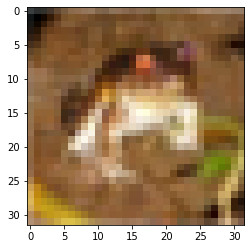

In [4]:
plt.imshow(x_train[0])
plt.show()

In [5]:
y_train[0]

array([6], dtype=uint8)

In [6]:
x_train.shape

(50000, 32, 32, 3)

In [7]:
y_train.shape

(50000, 1)

In [8]:
x_test.shape

(10000, 32, 32, 3)

In [9]:
y_test.shape

(10000, 1)

### 搭建卷积神经网络

本次用于训练 CIFAR-10 数据集的网络结构，有三层网络（不算输入层）：一层卷积层和两层全连接层。基本参数如下：

**注** CBAPD 即 **C**onvolutional、**B**atch Normalization、**A**ctivation、**P**ooling、**D**ropout

 + 第一层：卷积层
  + C：使用 6 个 $5\times5$ 的卷积核，步长为 1，全 0 填充（same）
  + B：使用批标准化
  + A：使用 ReLu 激活函数
  + P：使用 $2\times2$ 的池化核，采用最大值池化，步长为 2，全 0 填充（same）
  + D：Droput 概率为 0.2
 + Flatten 拉伸卷积层传来的输入特征
 + 第二层：全连接层
  + 128 个神经元
  + 使用 ReLu 激活函数
  + Dropout 概率为 0.2
 + 第三层：全连接层（输出层）
  + 10 个神经元
  + 使用 softmax 激活函数
  
因为网络结构过于复杂，所以建议使用继承 Model 类的方式实现网络结构。本次实现的是 CNN 的 baseline 版本，后续会在该 baseline 版本的基础上不断改进网络结构。

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout, Flatten, Dense
import os

In [11]:
class Baseline(Model):
    def __init__(self):
        super(Baseline, self).__init__()
        self.c1 = Conv2D(filters=6, kernel_size=(5, 5), padding='same')
        self.b1 = BatchNormalization()
        self.a1 = Activation('relu')
        self.p1 = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')
        self.d1 = Dropout(0.2)
    
        self.flatten = Flatten()
        self.f1 = Dense(128, activation='relu')
        self.d2 = Dropout(0.2)
        
        self.f2 = Dense(10, activation='softmax')
        
        
    def call(self, x):
        x = self.c1(x)
        x = self.b1(x)
        x = self.a1(x)
        x = self.p1(x)
        x = self.d1(x)
        
        x = self.flatten(x)
        x = self.f1(x)
        x = self.d2(x)
        y = self.f2(x)
        return y

基于之前“六步法”搭建神经网络的经验，逐步写出代码：

In [12]:
# 归一化
x_train, x_test = x_train / 255.0, x_test / 255.0

In [13]:
model = Baseline()

In [14]:
# 配置模型参数
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['sparse_categorical_accuracy'])

In [15]:
# 设置断点续训
checkpoint_save_path = './checkpoint/Baseline.ckpt'
if os.path.exists(checkpoint_save_path + '.index'):
    model.load_weights(checkpoint_save_path)

In [16]:
# 设置保存最优模型参数回调
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                save_weights_only=True,
                                                save_best_only=True)

In [17]:
# 训练模型
history = model.fit(x_train, y_train,
                   batch_size=32,
                   epochs=5,
                   validation_data=(x_test, y_test),
                   validation_freq=1,
                   callbacks=[cp_callback])

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 52s 1ms/sample - loss: 1.2402 - sparse_categorical_accuracy: 0.5563 - val_loss: 1.1496 - val_sparse_categorical_accuracy: 0.5937
Epoch 2/5
50000/50000 [==============================] - 48s 958us/sample - loss: 1.2120 - sparse_categorical_accuracy: 0.5685 - val_loss: 1.1529 - val_sparse_categorical_accuracy: 0.5891
Epoch 3/5
50000/50000 [==============================] - 50s 1ms/sample - loss: 1.1822 - sparse_categorical_accuracy: 0.5788 - val_loss: 1.2849 - val_sparse_categorical_accuracy: 0.5486
Epoch 4/5
50000/50000 [==============================] - 48s 952us/sample - loss: 1.1570 - sparse_categorical_accuracy: 0.5889 - val_loss: 1.1373 - val_sparse_categorical_accuracy: 0.6008- l
Epoch 5/5
50000/50000 [==============================] - 48s 955us/sample - loss: 1.1398 - sparse_categorical_accuracy: 0.5957 - val_loss: 1.1785 - val_sparse_categorical_accuracy: 0.5848


In [18]:
# 打印网络结构
model.summary()

Model: "baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  456       
_________________________________________________________________
batch_normalization (BatchNo multiple                  24        
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  196

In [19]:
np.set_printoptions(threshold=np.inf)
# 保存参数信息
with open('./data/weights.txt', 'w') as file:
    for v in model.trainable_variables:
        file.write(str(v.name) + '\n')
        file.write(str(v.shape) + '\n')
        file.write(str(v.numpy()) + '\n')

In [20]:
# 获取 acc 和 loss 曲线数据
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

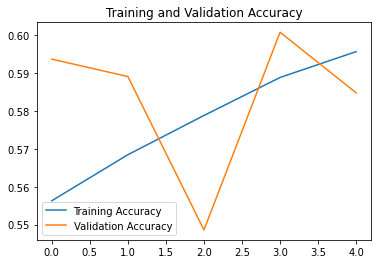

In [21]:
# 可视化 acc 曲线
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

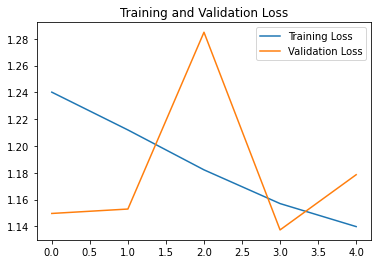

In [22]:
# 可视化 loss 曲线
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()